# This script generates a video of general hive visualisation

## Imports

In [1]:
import multiprocessing, cv2, os, sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
sys.path.append(os.path.abspath('ABCThermalPlots'))
sys.path.append(os.path.abspath('ABCImaging'))
from libvisu import *
from ABCImaging.libimage import fetchImagesPaths
from ABCImaging.VideoManagment.videolib import generateVideoFromList
from InfluxDBInterface.libdb import download_data_DB
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers
from dask.distributed import Client
# Start a client using all CPUs of this machine
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/scheduler-5zfsobbt', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-hci3cu9_', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-tmbynu37', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-k9h47zzx', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-r0y1jpn8', purging
INFO:distributed.

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50847,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50892,Total threads: 3
Dashboard: http://127.0.0.1:50896/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:50850,


## Configuration

In [2]:
# ==== GENERAL SETTINGS ====
download_data = True    # Set to True to download data from InfluxDB, False to use data stored locally
hive_nb = 1             # Hive number to process (1 or 2 for OH, 3 for BH and 0 for debugging)
t_res = "5min"          # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.11_aSensing4_OH/Images/'     # For images
first_dt = pd.to_datetime("251028-161000Z", format='%y%m%d-%H%M%S%z')
last_dt = pd.to_datetime("251103-100000Z", format='%y%m%d-%H%M%S%z')
frame_drop = 2          # We keep 1 frame every frame_drop frames. Put one to keep all frames.
verbose = True          # Set to True to print progress messages

# ==== LOCAL DATA CONFIGURATION ====
if not download_data:
    data_path = 'data/2025-10-06_13-18_influxdb_data.csv' # Path to the local .csv or .dat file containing the CO2, htr and tmp data

# ==== DATA DOWNLOAD CONFIGURATION ====
if download_data:
    bucket = 'a_sensing' # InfluxDB bucket to download data from

## Main code

### Image fetching

In [3]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=first_dt, end=last_dt, freq=t_res)
datetimes = datetimes[::frame_drop]

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)
print(f"Found {len(imgs_paths)} images for hive {hive_nb} between {first_dt} and {last_dt}.")

Found 828 images for hive 1 between 2025-10-28 16:10:00+00:00 and 2025-11-03 10:00:00+00:00.


### Htr, co2 and tmp data fetching

In [4]:
if download_data:
    data_res = int(t_res[0]) * 60
    filters = {'hive_num': str(hive_nb),
               'measurement': ['co2', 'htr', 'tmp']}
    hive_data = download_data_DB(bucket, first_dt, last_dt, data_res, filters, verbose=verbose) # Restricted to our time frame and hive
else:
    data_path = os.path.abspath(data_path)          # Absolute path to the data
    hive_data = extractData(data_path, hive_nb, datetimes, verbose=False) # Restricted to our time frame and hive
print(hive_data.head())

Executing query:

    from(bucket: "a_sensing")
      |> range(start: 2025-10-28T16:05:00Z, stop: 2025-11-03T10:00:00Z)
      |> filter(fn: (r) => r["_measurement"] == "co2" or r["_measurement"] == "htr" or r["_measurement"] == "tmp")
      |> filter(fn: (r) => r["hive_num"] == "1")
      |> aggregateWindow(every: 300s, fn: last, createEmpty: false)
      |> yield(name: "last")
    
                                    _start                    _stop             _value     _field  _measurement board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid DeltaT actuator_instance content  filling_density
_time                                                                                                                                                                                                                                                                   
2025-10-30 09:40:00+00:00 2025-10-28 16:05:00+00:00 2025-11-03 10:00:00+00:00  16.66

### tmp fetching

In [5]:
upper, lower = generateThermalDF(hive_data)   # Only tmp data, in a format that can be used by ThermalFrame

# Seek the max and min values of the tmp data, in both upper and lower hives
# max_temp = max(upper.max().max(), lower.max().max())
# min_temp = min(upper.min().min(), lower.min().min())

max_temp = np.nanmax([upper.to_numpy(), lower.to_numpy()])
min_temp = np.nanmin([upper.to_numpy(), lower.to_numpy()])
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(lower)

Max temperature in the selected time range:  34.4453125
Min temperature in the selected time range:  1.421875
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21     t22     t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59     t60  t61  t62  t63
_time                                                                                                                                                                                         

### Metabolic data fetching

In [6]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data)

                              ul       ur    ll    lr  
_time                                                  
2025-10-30 09:40:00+00:00  1852.672     NaN NaN     NaN
2025-10-30 09:45:00+00:00  1893.031  2653.0 NaN  1327.0
2025-10-30 09:50:00+00:00  1843.287  2560.0 NaN  1241.0
2025-10-30 09:55:00+00:00  1924.028  2269.0 NaN  1249.0
2025-10-30 10:00:00+00:00  1818.345  2613.0 NaN  3809.0
...                             ...     ...  ..     ...
2025-11-03 09:40:00+00:00       NaN   628.0 NaN   607.0
2025-11-03 09:45:00+00:00       NaN   651.0 NaN   659.0
2025-11-03 09:50:00+00:00       NaN   851.0 NaN   793.0
2025-11-03 09:55:00+00:00       NaN  1222.0 NaN  1072.0
2025-11-03 10:00:00+00:00       NaN   685.0 NaN   805.0

[1157 rows x 4 columns]


### htr fetching

In [7]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr) # TODO: it is missing columns. Check why, and how we can avoid it from breaking the automation part at the bottom of the nb !!
print(lower_htr)

                                    _start                    _stop             _value    _field  board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid DeltaT actuator_instance content  filling_density
_time                                                                                                                                                                                                                                                     
2025-10-30 09:40:00+00:00 2025-10-28 16:05:00+00:00 2025-11-03 10:00:00+00:00  17.28125  avg_temp   abc03    EPFL      1       upper    2191217016663093217343026   bass       1     /dev/ttyACM0  True    0.0          h02        Unknown      Unknown   
2025-10-30 09:40:00+00:00 2025-10-28 16:05:00+00:00 2025-11-03 10:00:00+00:00   0.00000       pwm   abc03    EPFL      1       upper    2191217016663093217343026   bass       1     /dev/ttyACM0  True    0.0          h03        Unknown      Unknown

### Plotting

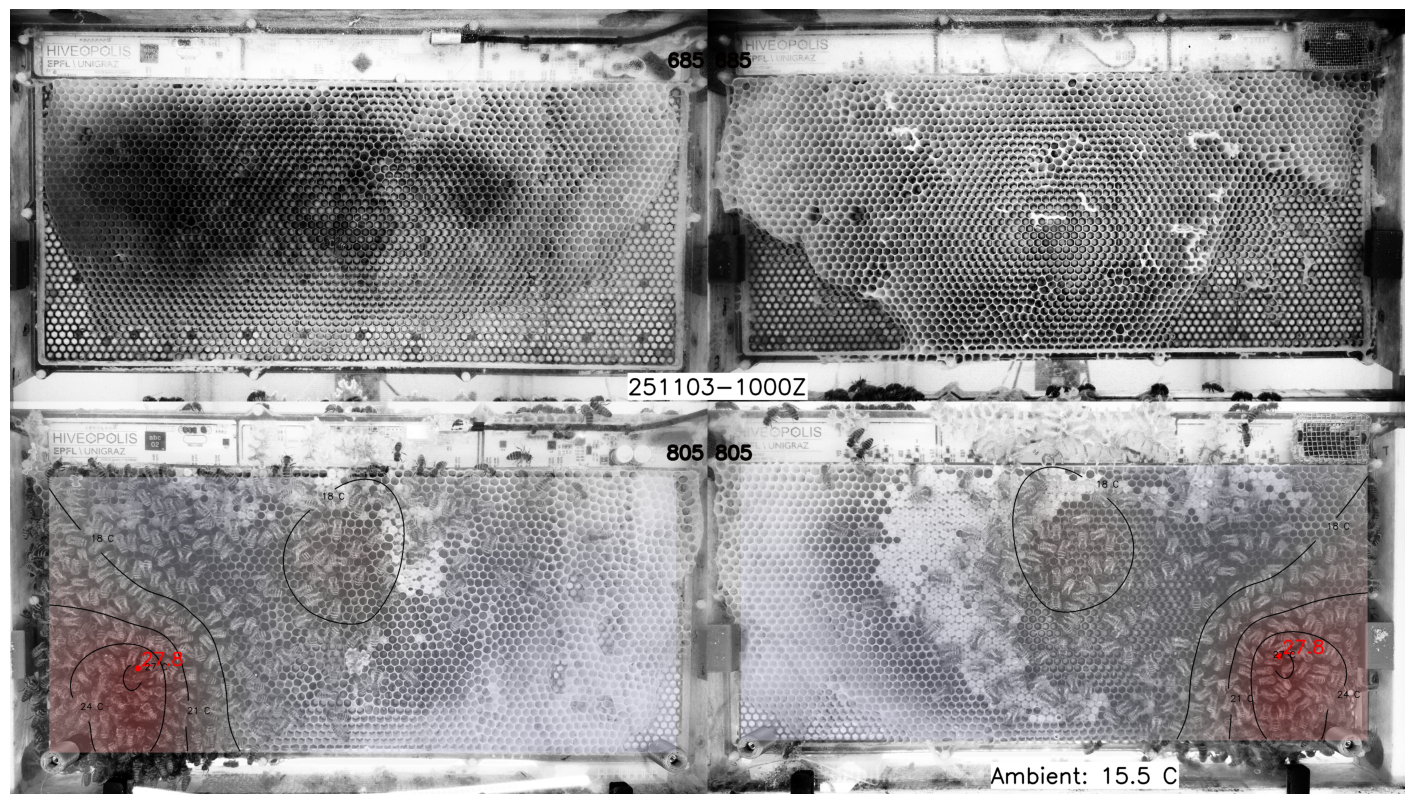

In [13]:
vmax = max_temp
vmin = min_temp
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
frame = -1 # Frame idx within datetimes
dt = datetimes[frame]
_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1][:-4] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]

# Thermal data
try:
    upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
except (NoValidSensors, KeyError):
    upper_tf = None

try:
    lower_tf = ThermalFrame(lower.loc[dt].to_numpy())
except (NoValidSensors, KeyError):
    lower_tf = None

# Metabolic data
if dt in co2_data.index:
    metabolic_df = co2_data.loc[dt]
else:
    metabolic_df = None

# Lower heater
if dt in lower_htr.index:
    lower_htr_row = lower_htr.loc[dt]
else:
    lower_htr_row = None

# Upper heater
if dt in upper_htr.index:
    upper_htr_row = upper_htr.loc[dt]
else:
    upper_htr_row = None

hs_1 = Hive(dt, current_imgs, False, imgs_names, upper_tf, lower_tf, metabolic_df, upper_htr_row, lower_htr_row, hive_nb=hive_nb)
contours = list(range(12, 37, 3))
snapshot = hs_1.snapshot(v_max=vmax, v_min=vmin, contours=contours, annotate_contours=True, annotate_names=False, thermal_transparency=0.35)
plt.imshow(snapshot)
plt.axis('off') 
plt.show()

### Automation

In [14]:
final_imgs = []
print("Generating frames...")
for dt in tqdm(datetimes):
    _imgs_paths = imgs_paths.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1][:-4] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(np.zeros((2592,4608), np.uint8))
        
    # Thermal data
    try:
        upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
    except (NoValidSensors, KeyError):
        upper_tf = None
    
    try:
        lower_tf = ThermalFrame(lower.loc[dt].to_numpy())
    except (NoValidSensors, KeyError):
        lower_tf = None

    # Metabolic data
    if dt in co2_data.index:
        metabolic_df = co2_data.loc[dt]
    else:
        metabolic_df = None

    # Lower heater
    if dt in lower_htr.index:
        lower_htr_row = lower_htr.loc[dt]
    else:
        lower_htr_row = None

    # Upper heater
    if dt in upper_htr.index:
        upper_htr_row = upper_htr.loc[dt]
    else:
        upper_htr_row = None

    hs = Hive(dt, current_imgs, False, imgs_names, upper_tf, lower_tf, metabolic_df, upper_htr_row, lower_htr_row, hive_nb=hive_nb)

    snapshot = hs.snapshot(v_max=max_temp, v_min=min_temp,contours=contours,annotate_contours=True, thermal_transparency=0.4)
    final_imgs.append(snapshot)

# Change frames from rgb to bgr
print("Convert frames to bgr...")
for i in tqdm(range(len(final_imgs))):
    final_imgs[i] = cv2.cvtColor(final_imgs[i], cv2.COLOR_RGB2BGR)

dest = "outputVideos/"
# Make this a global path
print("Saving video...")
generateVideoFromList(final_imgs, dest="outputVideos/", name=f"hive{hive_nb}_{first_dt.strftime('%y%m%d-%H%M%Z')}_{last_dt.strftime('%y%m%d-%H%M%Z')}", fps=10, grayscale=False)

# Cleanup step to release resources
multiprocessing.active_children()

Generating frames...


100%|██████████| 828/828 [10:39<00:00,  1.29it/s]


Convert frames to bgr...


100%|██████████| 828/828 [00:16<00:00, 51.09it/s] 


Saving video...


Writing video: 100%|██████████| 828/828 [01:33<00:00,  8.87frame/s]


[<SpawnProcess name='Dask Worker process (from Nanny)' pid=72936 parent=72910 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=72939 parent=72910 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=72938 parent=72910 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=72937 parent=72910 started daemon>]